In [1]:
!python -m pip install gwpy
!pip install astropy
!pip install nnAudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import signal
from glob import glob
from PIL import Image
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
import torch
import random
from nnAudio.Spectrogram import CQT1992v2


2025-08-28 14:18:39.757423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756390720.023292      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756390720.094608      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [3]:
# see how the data looks
file = "../input/g2net-gravitational-wave-detection/train/0/0/0/00000e74ad.npy"
data = np.load(file)
print(data.shape)
print(data)

(3, 4096)
[[-5.94830548e-21 -5.84995448e-21 -5.42415169e-21 ...
  -6.06698987e-21 -5.96345722e-21 -5.75778438e-21]
 [ 9.75407048e-22  4.52586118e-22  4.58643893e-23 ...
  -1.09608208e-20 -1.09766636e-20 -1.10858129e-20]
 [-1.74871983e-21 -1.18286791e-21 -1.93223777e-21 ...
   1.46502268e-21  2.18644864e-21  1.54085934e-21]]


In [4]:
def get_timeseries_from_file(file):
    data = np.load(file)
    t1 = TimeSeries(data[0,:],sample_rate=2048)
    t2 = TimeSeries(data[1,:],sample_rate=2048)
    t3 = TimeSeries(data[2,:],sample_rate=2048)
    return t1,t2,t3

In [5]:
def plot_timeseries(t1,t2,t3):
  plot = Plot(t1, t2, t3, separate=True, sharex=True, figsize=[20, 12])
  ax = plot.gca()
  ax.set_xlim(0, 2)
  ax.set_xlabel('Time [s]')
  plt.show()

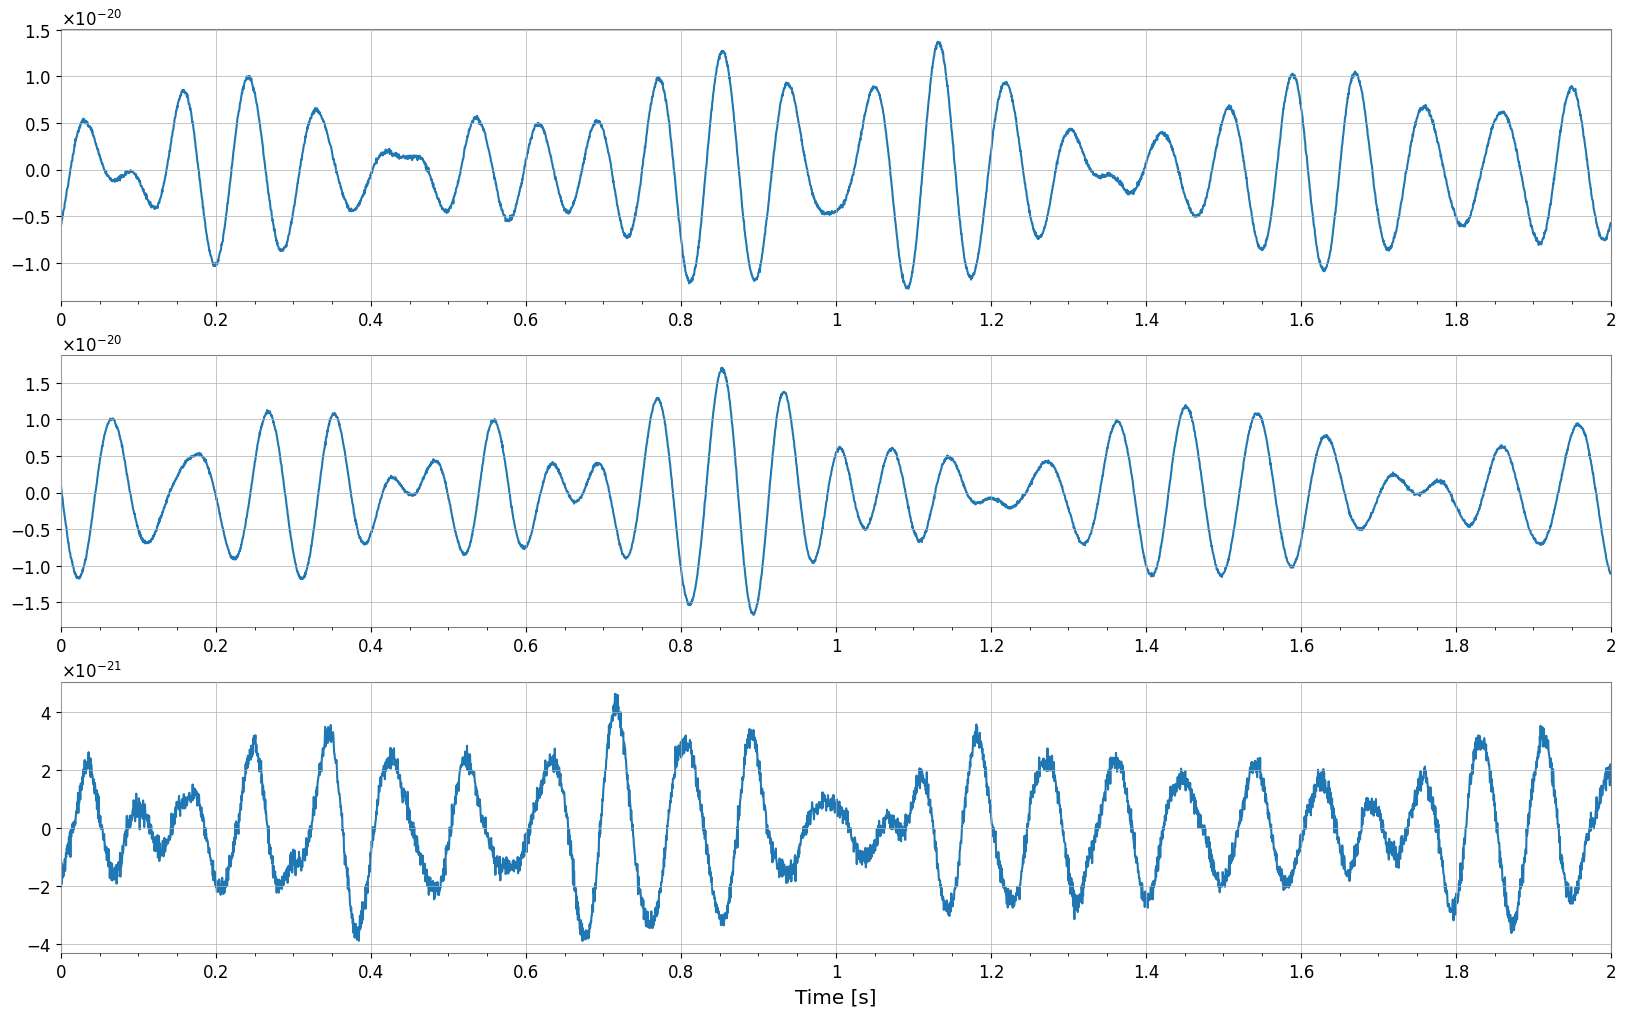

In [6]:
file = "../input/g2net-gravitational-wave-detection/train/0/0/0/00000e74ad.npy"
  
t1, t2, t3 = get_timeseries_from_file(file)

# Plotting the TimeSeries
plot_timeseries(t1, t2, t3)

In [7]:
train_paths = glob("../input/g2net-gravitational-wave-detection/train/*/*/*/*")

train_labels = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")

ids_from_npy_files = [path.split("/")[-1].split(".")[0] for path in train_paths]

df_path_id = pd.DataFrame({'path': train_paths, 'id':ids_from_npy_files})

df_path_target = pd.merge(train_labels,df_path_id,on='id')

df_path_target.head()



,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...
